In [ ]:
import math
import torch
import random
import tarfile
import torchtext
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader

In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
SEED = 12345
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
with tarfile.open("/content/drive/MyDrive/MT/training.tar.gz", "r") as tf:
  print("Opened tarfile")
  tf.extractall(path="/content")
  print("All files extracted")

Opened tarfile
All files extracted


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [ ]:
en_tok_model = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
de_tok_model = torchtext.data.utils.get_tokenizer('spacy', language='de_core_news_sm')

In [ ]:
def de_tokenizer(sentence):
  return de_tok_model(sentence)

def en_tokenizer(sentence):
  return en_tok_model(sentence)

In [ ]:
class Data():
  def __init__(self, en_filename, de_filename):
    self.en_file = open(en_filename, mode='rt', encoding='utf-8')
    self.en_text = self.en_file.read()
    self.en_file.close()
    self.de_file = open(de_filename, mode='rt', encoding='utf-8')
    self.de_text = self.de_file.read()
    self.de_file.close()
    self.en_text = self.en_text.strip().split('\n')
    self.de_text = self.de_text.strip().split('\n')
  def data(self):
    return self.en_text, self.de_text

In [ ]:
class Vocab():
  def __init__(self, en_filename, de_filename):
    self.en_len = 0
    self.de_len = 0
    self.en_count = Counter()
    self.de_count = Counter()
    self.en_data, self.de_data = Data(en_filename, de_filename).data()
    for idx in range(len(self.en_data)):
      self.en_sent = self.en_data[idx]
      self.de_sent = self.de_data[idx]
      self.en_sent = ['<SOS>'] + en_tokenizer(self.en_sent.lower().strip()) + ['<EOS>']
      self.de_sent = ['<SOS>'] + de_tokenizer(self.de_sent.lower().strip()) + ['<EOS>']
      if(len(self.en_sent) > self.en_len):
        self.en_len = len(self.en_sent)
      if(len(self.de_sent) > self.de_len):
        self.de_len = len(self.de_sent)
      self.en_count.update(self.en_sent)
      self.de_count.update(self.de_sent)
    self.en_vocab = set()
    for k,c in self.en_count.items():
      if len(self.en_vocab)<8190 :
        self.en_vocab.add(k)
    self.en_vocab.add('<PAD>')
    self.de_vocab = set()
    for k,c in self.de_count.items():
      if len(self.de_vocab)<8190 :
        self.de_vocab.add(k)
    self.de_vocab.add('<PAD>')
  def vocab(self):
    return self.en_vocab, self.de_vocab, self.en_len, self.de_len

In [ ]:
class Multi30K(Dataset):
  def __init__(self, en_filename, de_filename):
    self.en_data, self.de_data = Data(en_filename, de_filename).data()
    self.en_vocab, self.de_vocab, self.en_len, self.de_len = Vocab(en_filename, de_filename).vocab()
    self.en_word2idx = {w: idx for (idx, w) in enumerate(self.en_vocab)}
    self.en_word2idx.update({'<UNK>' : len(self.en_word2idx)})
    self.en_idx2word = {idx: w for (idx, w) in enumerate(self.en_vocab)}
    self.en_idx2word.update({len(self.en_idx2word) : '<UNK>'})
    self.de_word2idx = {w: idx for (idx, w) in enumerate(self.de_vocab)}
    self.de_word2idx.update({'<UNK>' : len(self.de_word2idx)})
    self.de_idx2word = {idx: w for (idx, w) in enumerate(self.de_vocab)}
    self.de_idx2word.update({len(self.de_idx2word) : '<UNK>'})

  def __len__(self):
    return len(self.en_data)

  def __getitem__(self, index):
    en_sent = self.en_data[index]
    de_sent = self.de_data[index]
    en_sent = ['<SOS>'] + en_tokenizer(en_sent.lower().strip()) + ['<EOS>']
    de_sent = ['<SOS>'] + de_tokenizer(de_sent.lower().strip()) + ['<EOS>']
    for i in range(len(en_sent)):
      if en_sent[i] in self.en_vocab:
        en_sent[i] = self.en_word2idx[en_sent[i]]
      else:
        en_sent[i] = self.en_word2idx['<UNK>']
    for i in range(len(de_sent)):
      if de_sent[i] in self.de_vocab:
        de_sent[i] = self.de_word2idx[de_sent[i]]
      else:
        de_sent[i] = self.de_word2idx['<UNK>']
    for i in range(len(en_sent), self.en_len):
      en_sent.append(self.en_word2idx['<PAD>'])
    for i in range(len(de_sent), self.de_len):
      de_sent.append(self.de_word2idx['<PAD>'])
    en_sent = torch.tensor(en_sent)
    de_sent = torch.tensor(de_sent)
    return en_sent, de_sent

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
    super().__init__()
    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
    self.fc = nn.Linear(enc_hid_dim, dec_hid_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, src):
    src = src.transpose(0, 1)
    embedded = self.dropout(self.embedding(src)).transpose(0, 1)
    enc_output, enc_hidden = self.rnn(embedded)
    h_n = torch.tanh(self.fc(enc_hidden))
    return enc_output, h_n

In [ ]:
class Attention(nn.Module):
  def __init__(self, enc_hid_dim, dec_hid_dim):
    super().__init__()
    self.attn = nn.Linear((enc_hid_dim*2) + 2*dec_hid_dim, dec_hid_dim, bias=False)
    self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, h_n, enc_output, mask):
    batch_size = enc_output.shape[1]
    src_len = enc_output.shape[0]
    h_n = h_n.reshape(h_n.size(1), h_n.size(0)*h_n.size(2))
    h_n = h_n.unsqueeze(1).repeat(1, src_len, 1)
    enc_output = enc_output.transpose(0, 1)
    energy = torch.tanh(self.attn(torch.cat((h_n, enc_output), dim = 2)))
    attention = self.v(energy).squeeze(2)
    attention = attention.masked_fill(mask == 0, -1e10)
    attention = self.softmax(attention).unsqueeze(1)
    weighted = torch.bmm(attention, enc_output)
    return weighted.permute(1, 0, 2), attention

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
    super().__init__()
    self.output_dim = output_dim
    self.attention = attention
    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.rnn = nn.GRU((enc_hid_dim*2) + emb_dim, dec_hid_dim, num_layers=2)
    self.fc_out = nn.Linear((enc_hid_dim*2) + dec_hid_dim + emb_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, dec_input, h_n, enc_output, mask):
    dec_input = dec_input.unsqueeze(1)
    embedded = self.dropout(self.embedding(dec_input)).transpose(0, 1)
    weighted, attend = self.attention(h_n, enc_output, mask)
    rnn_input = torch.cat((embedded, weighted), dim = 2)
    dec_output, dec_hidden = self.rnn(rnn_input, h_n)
    embedded = embedded.squeeze(0)
    dec_output = dec_output.squeeze(0)
    weighted = weighted.squeeze(0)
    pred = self.fc_out(torch.cat((dec_output, weighted, embedded), dim=1))
    return pred, dec_hidden

In [ ]:
class Model(nn.Module):
  def __init__(self, encoder, decoder, device, src_pad_idx):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    self.src_pad_idx = src_pad_idx

  def create_mask(self, source):
    mask = (source != self.src_pad_idx).permute(1, 0)
    return mask

  def forward(self, src, trg, teacher_forcing_ratio = 0.5):
    batch_size = src.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    enc_output, h_n = self.encoder(src)
    dec_input = trg[0,:]
    mask = self.create_mask(src)
    for t in range(1, trg_len):
      dec_output, h_n = self.decoder(dec_input, h_n, enc_output, mask)
      outputs[t] = dec_output
      teacher_force = random.random() < teacher_forcing_ratio
      top = dec_output.argmax(1)
      dec_input = trg[t] if teacher_force else top
    return outputs

In [ ]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}

In [ ]:
dataset = Multi30K('/content/train.en', '/content/train.de')
data = DataLoader(dataset, **params)

In [ ]:
en_vocab_size = len(dataset.en_vocab)
de_vocab_size = len(dataset.de_vocab)
print("German Vocab Size : ", de_vocab_size)
print("English Vocab Size : ", en_vocab_size)

German Vocab Size :  8191
English Vocab Size :  8191


In [ ]:
INPUT_DIM = en_vocab_size+1
OUTPUT_DIM = de_vocab_size+1
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Model(enc, dec, device, dataset.en_word2idx["<PAD>"]).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.de_word2idx["<PAD>"])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_loss, train_perplexity = [], []
valid_loss, valid_perplexity = [], []
for epoch in range(10):
  epoch_loss = 0
  for t, (en,de) in enumerate(data):
    if t < 906:
      en = en.mT.to(device)
      de = de.mT.to(device)
      out = model(en, de)
      loss = criterion(out.reshape(-1, out.shape[2]), de.reshape(-1))
      epoch_loss += float(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      en = en.mT.to(device)
      de = de.mT.to(device)
      out = model(en, de)
      loss = criterion(out.reshape(-1, out.shape[2]), de.reshape(-1))
      out = torch.argmax(out, dim=2)

  valid_loss.append(float(loss))
  train_loss.append(epoch_loss/len(data))
  valid_perplexity.append(float(torch.exp(loss)))
  train_perplexity.append(math.exp(epoch_loss/len(data)))
  print("-"*25, f"Epoch {epoch + 1}","-"*25)
  print("Train Loss : ", round(train_loss[-1],3), "Train Perplexity : ", round(train_perplexity[-1],3))
  print("Valid Loss : ", round(valid_loss[-1],3), "Valid Perplexity : ", round(valid_perplexity[-1],3))

------------------------- Epoch 1 -------------------------
Train Loss :  4.013 Train Perplexity :  55.304
Valid Loss :  3.402 Valid Perplexity :  30.032
------------------------- Epoch 2 -------------------------
Train Loss :  3.125 Train Perplexity :  22.761
Valid Loss :  3.191 Valid Perplexity :  24.308
------------------------- Epoch 3 -------------------------
Train Loss :  2.78 Train Perplexity :  16.115
Valid Loss :  2.808 Valid Perplexity :  16.572
------------------------- Epoch 4 -------------------------
Train Loss :  2.595 Train Perplexity :  13.394
Valid Loss :  2.419 Valid Perplexity :  11.237
------------------------- Epoch 5 -------------------------
Train Loss :  2.484 Train Perplexity :  11.987
Valid Loss :  2.741 Valid Perplexity :  15.503
------------------------- Epoch 6 -------------------------
Train Loss :  2.42 Train Perplexity :  11.242
Valid Loss :  2.301 Valid Perplexity :  9.989
------------------------- Epoch 7 -------------------------
Train Loss :  2.353

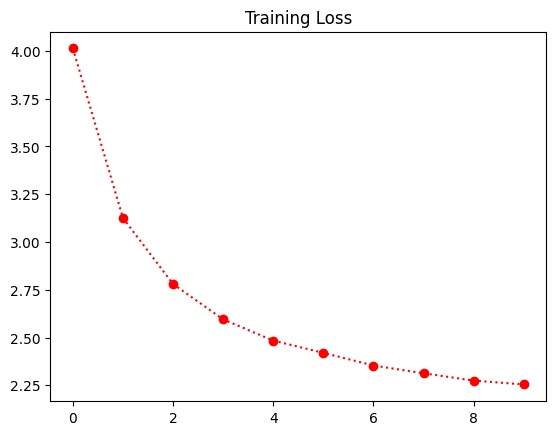

In [ ]:
plt.plot(train_loss, 'o:r')
plt.title("Training Loss")
plt.show()

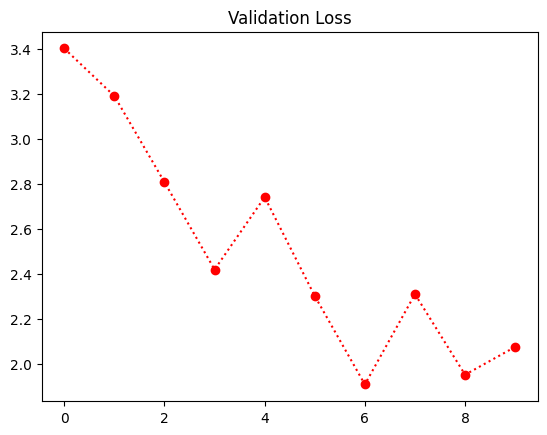

In [ ]:
plt.plot(valid_loss, 'o:r')
plt.title("Validation Loss")
plt.show()

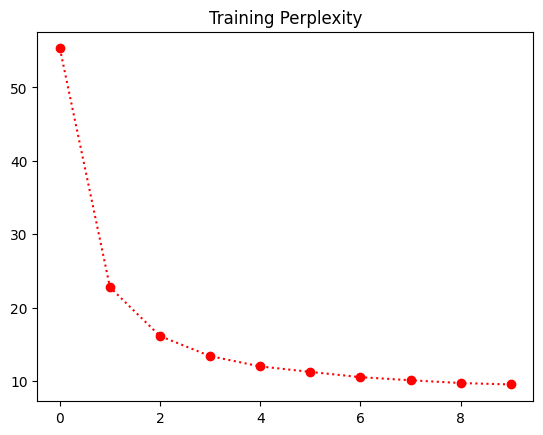

In [ ]:
plt.plot(train_perplexity, 'o:r')
plt.title("Training Perplexity")
plt.show()

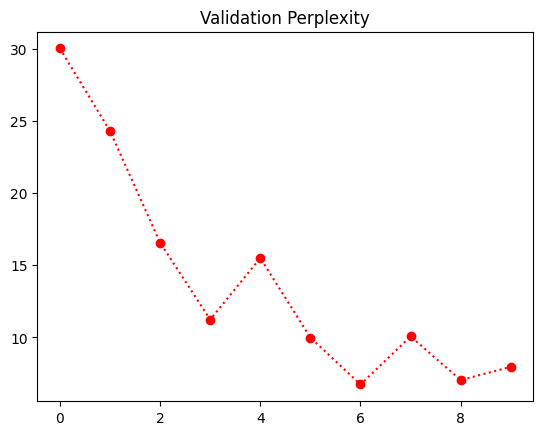

In [ ]:
plt.plot(valid_perplexity, 'o:r')
plt.title("Validation Perplexity")
plt.show()

In [ ]:
def Translate(src_sentence, model):
  model.eval()
  with torch.no_grad():
    enc_hid, h_n = model.encoder(src_sentence)
  dec_states = h_n
  sos_id = dataset.de_word2idx['<SOS>']
  eos_id = dataset.de_word2idx['<EOS>']
  predicts = [sos_id]
  len = 1
  max_len = 40
  src_mask = model.create_mask(src_sentence)
  while len < max_len:
    inp = torch.LongTensor([predicts[-1]]).view((1)).to(device)
    with torch.no_grad():
      outputs, dec_states = model.decoder(inp, dec_states, enc_hid, src_mask)
    outputs = outputs.squeeze()
    outputs = outputs.view(-1, 8192)
    predicts.append(outputs.argmax(-1).item())
    len += 1
    if predicts[-1] == eos_id:
      break
  sentence = [dataset.de_idx2word[id] for id in predicts]
  return sentence

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def CalcBELU(model, dataset):
  belu_score = 0
  for n in range(1,9):
    true_translation = []
    (en,de) = dataset[-n]
    en = en.resize_(en.size(0),1).to(device)
    pred_translation = Translate(en, model)
    for id in de:
      if id != dataset.de_word2idx['<PAD>']:
        true_translation.append(dataset.de_idx2word[int(id)])
    belu_score += float(sentence_bleu([pred_translation], true_translation))
  return belu_score/8

In [ ]:
print("Obtained BELU Score : ", CalcBELU(model, dataset)*100)

Obtained BELU Score :  30.47930138369077


In [ ]:
txt = input("Enter A Text : ")
txt = en_tokenizer(txt.lower().strip())
for i in range(len(txt)):
  if txt[i] in dataset.en_vocab:
    txt[i] = dataset.en_word2idx[txt[i]]
  else:
    txt[i] = dataset.en_word2idx['<UNK>']
  for i in range(len(txt), dataset.en_len):
    txt.append(dataset.en_word2idx['<PAD>'])
txt = torch.tensor(txt)
txt.resize_(len(txt), 1)
txt = txt.to(device)
german = Translate(txt, model)
print(german)

Enter A Text : A group of people having a barbecue at a park.
['<SOS>', 'eine', 'gruppe', 'von', 'personen', 'in', 'einem', 'park', 'eine', 'gruppe', 'von', 'menschen', '.', '<EOS>']
